Imports

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox

plt.rcParams['figure.figsize'] = [10, 5]

Read Data

In [14]:
raw_songs = pd.read_csv('taylor_swift_spotify.csv', index_col=0)

songs = raw_songs.drop(columns=['id', 'uri'])
songs.head()

,name,album,release_date,track_number,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,duration_ms
0,Welcome To New York (Taylor's Version),1989 (Taylor's Version) [Deluxe],2023-10-27,1,0.009420,0.757,0.610,0.000037,0.3670,-4.840,0.0327,116.998,0.685,66,212600
1,Blank Space (Taylor's Version),1989 (Taylor's Version) [Deluxe],2023-10-27,2,0.088500,0.733,0.733,0.000000,0.1680,-5.376,0.0670,96.057,0.701,67,231833
2,Style (Taylor's Version),1989 (Taylor's Version) [Deluxe],2023-10-27,3,0.000421,0.511,0.822,0.019700,0.0899,-4.785,0.0397,94.868,0.305,68,231000
3,Out Of The Woods (Taylor's Version),1989 (Taylor's Version) [Deluxe],2023-10-27,4,0.000537,0.545,0.885,0.000056,0.3850,-5.968,0.0447,92.021,0.206,67,235800
4,All You Had To Do Was Stay (Taylor's Version),1989 (Taylor's Version) [Deluxe],2023-10-27,5,0.000656,0.588,0.721,0.000000,0.1310,-5.579,0.0317,96.997,0.520,65,193289


Meaning of each variable: https://developer.spotify.com/documentation/web-api/reference/get-audio-features

Initial Plot

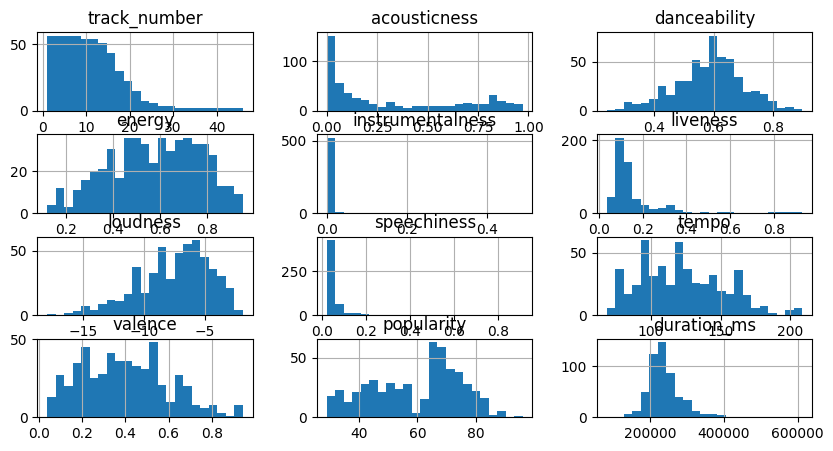

In [15]:
songs.hist(bins=23) 
plt.show()

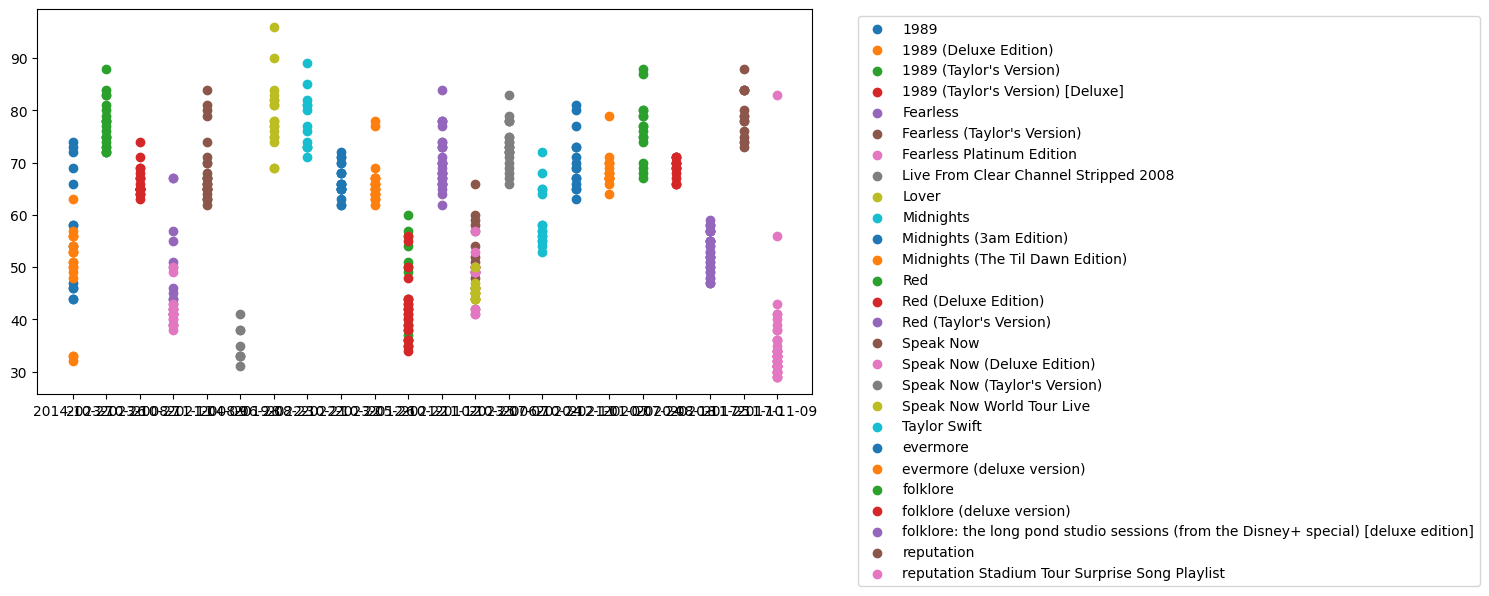

In [16]:
album_names = songs['album'].astype('category').cat.categories
plt.figure(figsize=(10, 5))

for album in album_names:
    subset = songs[songs['album'] == album]
    plt.scatter(subset['release_date'], subset['popularity'], label=album)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

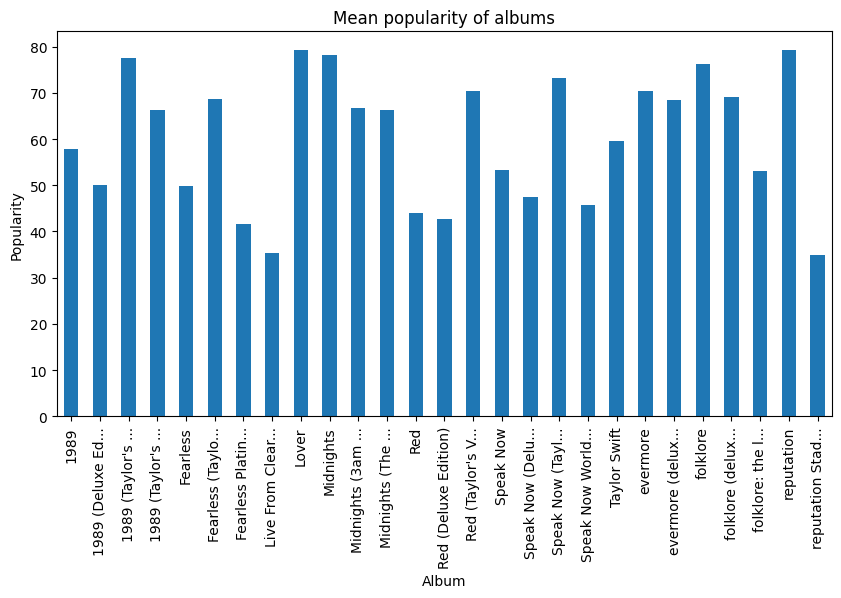

In [17]:
df = songs.groupby('album')['popularity'].mean()
df.index = np.where(df.index.str.len() > 20, df.index.str.slice(0, 15) + '...', df.index)
# np.where(df.index.str.len() > 15, df.index.str.slice(0, 15) + '...', df.index)
df.plot(kind='bar')
plt.xlabel('Album')
plt.ylabel('Popularity')
plt.title('Mean popularity of albums')
plt.show()

### Removing Outlier Observations

We can see that there is one song that feature Taylor Swift, but in fact, this song isn't hers (it's from Zayn). The song is called "I Don’t Wanna Live Forever (Fifty Shades Darker)"

In [18]:
songs = songs[songs['name'] != "I Don’t Wanna Live Forever (Fifty Shades Darker)"]

### Duration Scaling (from ms to s)

In [19]:
songs['duration_ms'] = songs['duration_ms'] / 1000
songs.rename(columns={'duration_ms': 'duration'}, inplace=True)

songs['duration'].head()

0    212.600
1    231.833
2    231.000
3    235.800
4    193.289
Name: duration, dtype: float64

### Removing voice memo

Not songs, rather commentaries about the making off.

In [21]:
songs = songs[~songs.name.str.contains('Voice Memo')]

songs[songs.name.str.contains('Voice Memo')]

,name,album,release_date,track_number,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,duration


### Categorical Variables: taylor_version, not_first_release, live

#### Taylor's Version

In [22]:
songs['taylors_version'] = songs['name'].str.contains('Taylor\'s Version|Taylor’s Version')
songs['taylors_version'].value_counts()

taylors_version
False    405
True     121
Name: count, dtype: int64

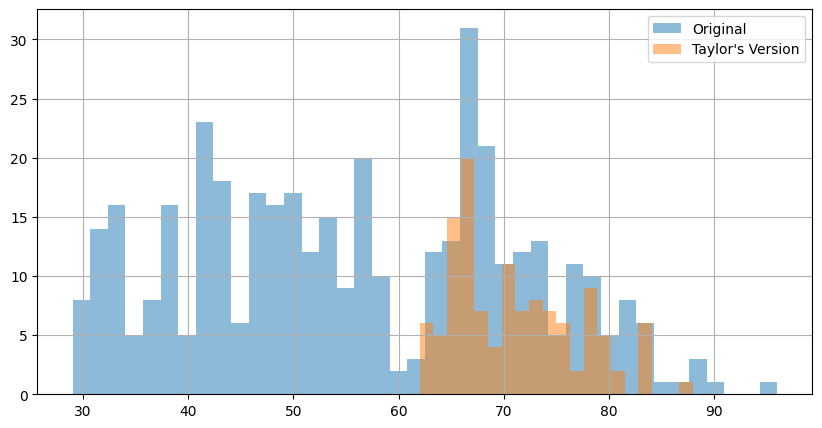

In [23]:
songs[songs['taylors_version'] == False]['popularity'].hist(bins=40, alpha=0.5)
songs[songs['taylors_version'] == True ]['popularity'].hist(bins=20, alpha=0.5)
plt.legend(['Original', 'Taylor\'s Version'])
plt.show()

#### Performed_live categorical variable

In [24]:
live_albums = ["Live From Clear Channel Stripped 2008", "Speak Now World Tour Live", "reputation Stadium Tour Surprise Song Playlist"]
songs['performed_live'] = songs['album'].isin(live_albums)

songs_without_live = songs[~songs['performed_live']]

songs['performed_live'].value_counts()

performed_live
False    457
True      69
Name: count, dtype: int64

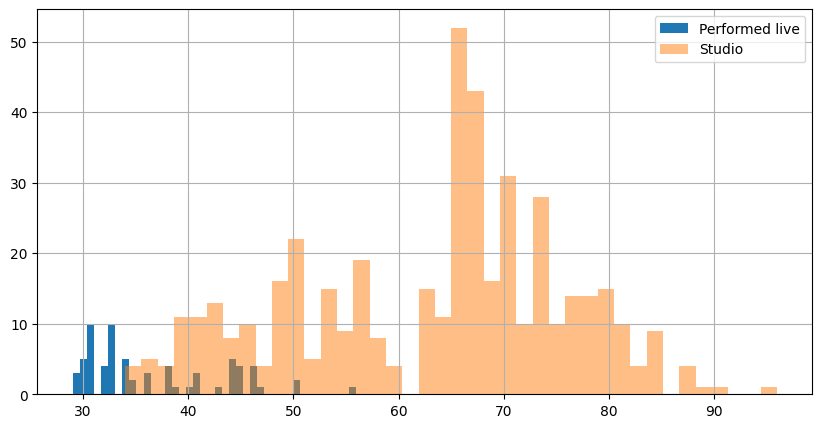

In [25]:
songs[songs['performed_live'] == True ]['popularity'].hist(bins=40, alpha=1)
songs[songs['performed_live'] == False]['popularity'].hist(bins=40, alpha=0.5)
plt.legend(['Performed live', 'Studio'])
plt.show()

Midnights

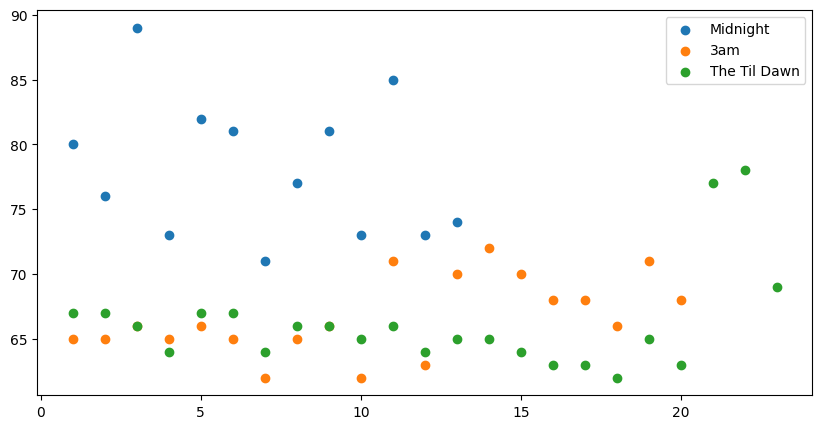

['Hits Different', 'Snow On The Beach (feat. More Lana Del Rey)', 'Karma (feat. Ice Spice)']


In [26]:
midnight = songs[songs['album'] == 'Midnights']
three_am = songs[songs['album'].str.contains('3am')]
til_the_dawn = songs[songs['album'].str.contains('The Til Dawn Edition')]

plt.scatter(midnight['track_number'], midnight['popularity'])
plt.scatter(three_am['track_number'], three_am['popularity'])
plt.scatter(til_the_dawn['track_number'], til_the_dawn['popularity'])
plt.legend(['Midnight', '3am', 'The Til Dawn'])
plt.show()

from itertools import zip_longest
print( list(s1 for s2, s1 in zip_longest(three_am['name'], til_the_dawn['name']) if s1 != s2 ))

Folklore

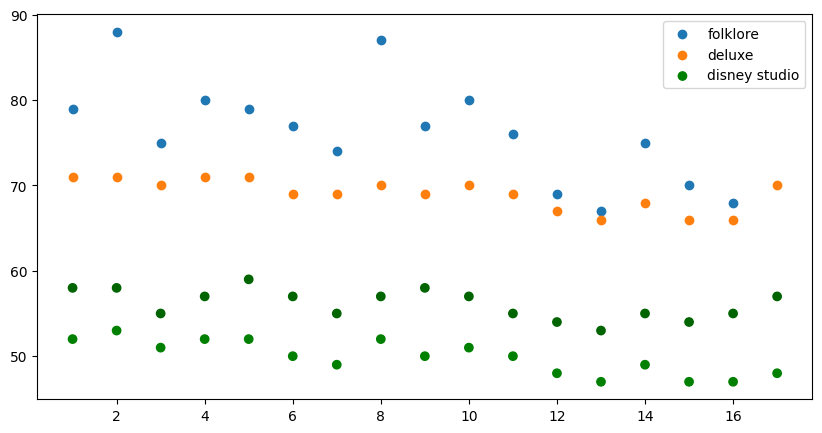

In [27]:

folklore = songs[songs['album'] == 'folklore']
deluxe = songs[songs['album'] == 'folklore (deluxe version)']
studio = songs[songs['album'] == 'folklore: the long pond studio sessions (from the Disney+ special) [deluxe edition]']

plt.scatter(folklore['track_number'], folklore['popularity'])
plt.scatter(deluxe['track_number'], deluxe['popularity'])
plt.scatter(studio['track_number'], studio['popularity'], c = ['green']* (len(studio)//2) + ['darkgreen']*(len(studio)//2))
plt.legend(['folklore', 'deluxe', 'disney studio'])
plt.show()

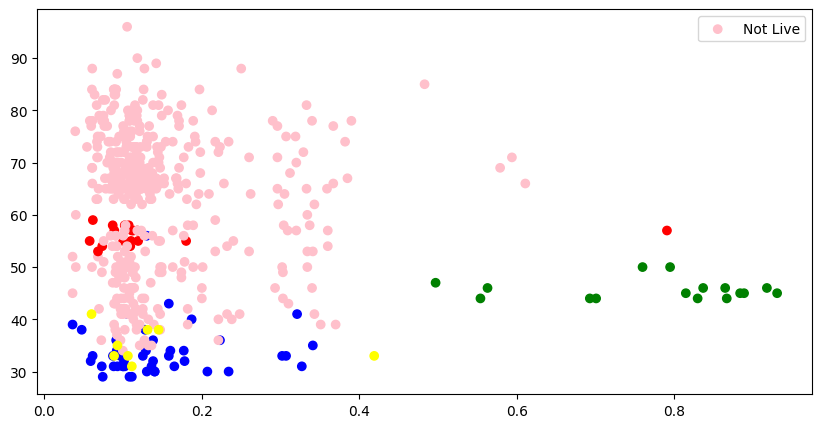

In [28]:
a = songs['name'].str.contains('the long pond')# & songs['track_number'] > 17
b = (songs['album'] == 'Speak Now World Tour Live')
c = (songs['album'] == 'reputation Stadium Tour Surprise Song Playlist')
d = songs['performed_live']

colors = ['red' if x else 'green' if y else 'blue' if z else 'yellow' if w else 'pink' for x, y, z, w in zip(a, b, c, d)]


plt.scatter(songs['liveness'], songs['popularity'], c=colors)
plt.legend(['Not Live', 'Live', 'the long pond'])
plt.show()

Which is the Red observation that has very high liveness?

In [29]:
pd.DataFrame(songs.loc[songs[songs['album'] != 'Speak Now World Tour Live']['liveness'].idxmax()]).T

,name,album,release_date,track_number,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,duration,taylors_version,performed_live
233,august - the long pond studio sessions,folklore: the long pond studio sessions (from ...,2020-11-25,8,0.5,0.554,0.663,0.000048,0.791,-8.961,0.0324,89.977,0.545,57,260.0,False,False


We leave the songs as this (don't need to merge) with only a not_first_release indicator.

In [30]:
first_release_indexes = songs.groupby('name').apply(lambda group: group.index.max())

songs['not_first_release'] = songs.index != songs['name'].map(first_release_indexes)
songs['not_first_release'] &= ~songs['performed_live']

songs.loc[songs['album'].str.contains('the long pond'), 'not_first_release'] = True

/tmp/ipykernel_17868/421410992.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  first_release_indexes = songs.groupby('name').apply(lambda group: group.index.max())


In [31]:
name = 'Midnights (Deluxe Edition)'
name = name[:len('Midnights')].rstrip()
name
songs['album'].value_counts()

album
reputation Stadium Tour Surprise Song Playlist                                         45
folklore: the long pond studio sessions (from the Disney+ special) [deluxe edition]    34
Red (Taylor's Version)                                                                 30
Fearless (Taylor's Version)                                                            26
Midnights (The Til Dawn Edition)                                                       23
1989 (Taylor's Version) [Deluxe]                                                       22
Speak Now (Taylor's Version)                                                           22
Red (Deluxe Edition)                                                                   22
1989 (Taylor's Version)                                                                21
Midnights (3am Edition)                                                                20
Speak Now (Deluxe Edition)                                                             20
Fear

In [32]:
songs['album'] = songs['album'].apply(lambda name: name[:-len('(Deluxe Edition)')].rstrip() if '(Deluxe Edition)' in name else name)
songs['album'] = songs['album'].apply(lambda name: name[:-len('Platinum Edition')].rstrip() if 'Platinum Edition' in name else name)
songs['album'] = songs['album'].apply(lambda name: name[:-len('[Deluxe]')].rstrip() if '[Deluxe]' in name else name)
songs['album'] = songs['album'].apply(lambda name: name[:-len('(deluxe version)')].rstrip() if '(deluxe version)' in name else name)
songs.loc[songs['album'].str.contains('Midnights'), 'album'] = 'Midnights'
songs.loc[songs['album'].str.contains('folklore'), 'album'] = 'folklore'

songs['album'].value_counts()

album
folklore                                          67
Midnights                                         56
reputation Stadium Tour Surprise Song Playlist    45
1989 (Taylor's Version)                           43
Red                                               38
Speak Now                                         34
Fearless                                          32
evermore                                          32
Red (Taylor's Version)                            30
1989                                              29
Fearless (Taylor's Version)                       26
Speak Now (Taylor's Version)                      22
Lover                                             18
Speak Now World Tour Live                         16
reputation                                        15
Taylor Swift                                      15
Live From Clear Channel Stripped 2008              8
Name: count, dtype: int64

### Correlation of variables

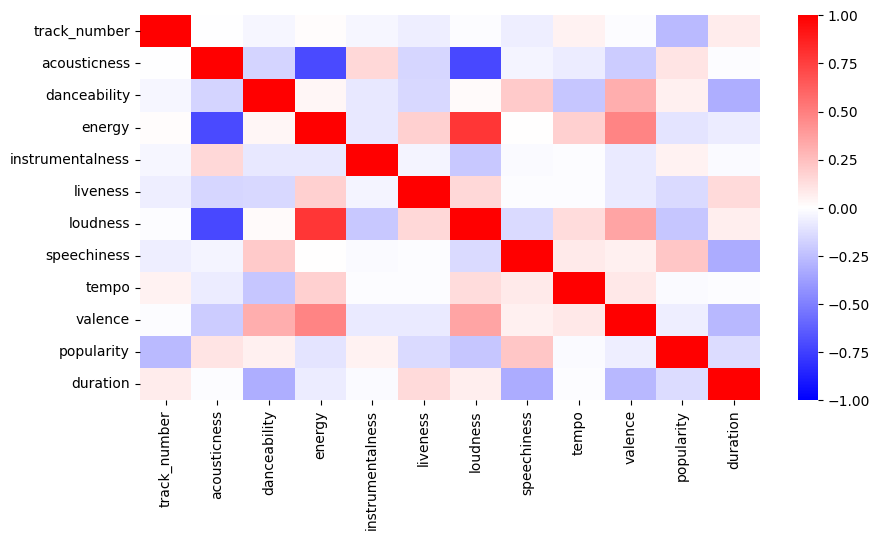

In [33]:
idx = range(3, 15) # numeric data
corr = songs.iloc[:, idx].corr()
sns.heatmap(corr, cmap='bwr', vmax=1, vmin=-1)
plt.show()

Problemes: veiem com acousticness, danceability, enrgy i loudness estan totes relacionades entre elles. A més a més, relase_date i popularity fortament correlades (ja ho sabíem).

### Popularity vs mean by album

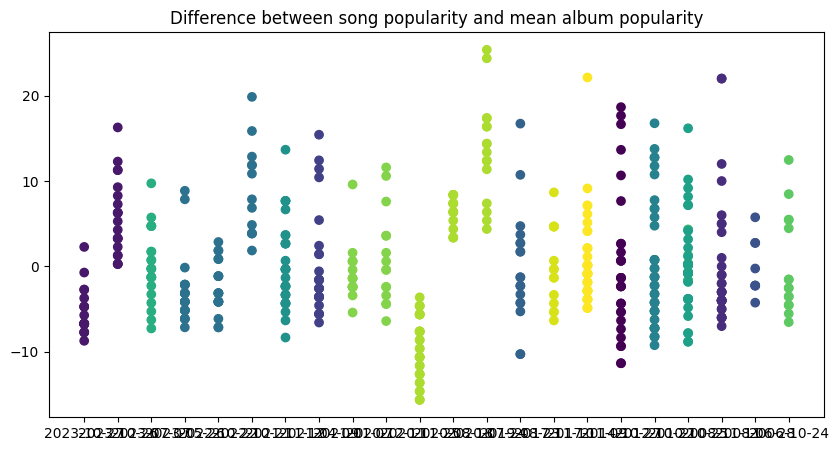

In [34]:
albums = songs.groupby('album')['popularity'].mean()

plt.scatter(songs['release_date'], songs['popularity'] - albums[songs['album']].values, c=songs['album'].astype('category').cat.codes)
plt.title("Difference between song popularity and mean album popularity")
plt.show()

#### Solving relase_date and popularity correlation:

the variable release_date contains vairability that is very hard to explain if we want to create a model that predicst popularity with only the parameters established earlier. Therefore, we have to delete it

In [35]:
songs.drop(columns=['release_date'], inplace=True)

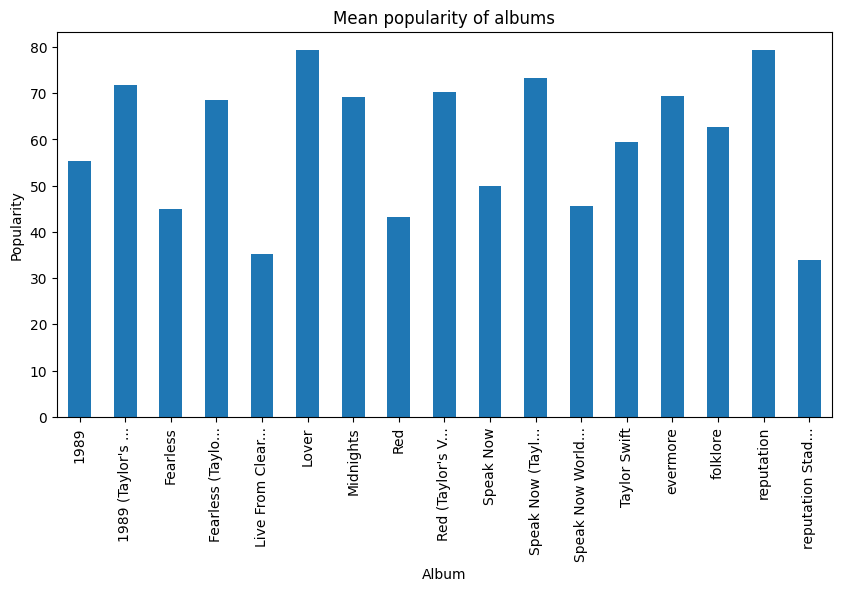

In [36]:
df = songs.groupby('album')['popularity'].mean()
df.index = np.where(df.index.str.len() > 20, df.index.str.slice(0, 15) + '...', df.index)
df.plot(kind='bar')
plt.xlabel('Album')
plt.ylabel('Popularity')
plt.title('Mean popularity of albums')
plt.show()

### Track Number

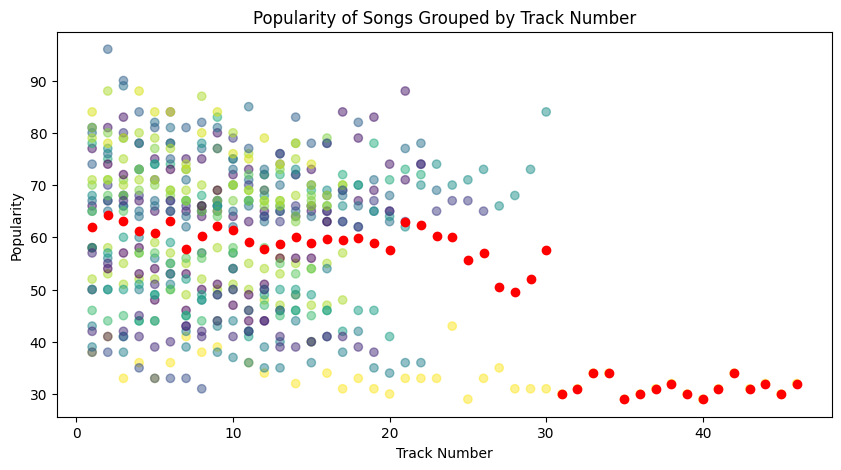

In [26]:
plt.scatter(songs['track_number'], songs['popularity'], c=songs['album'].astype('category').cat.codes, alpha=0.5)

grouped_songs = songs.groupby('track_number')['popularity'].mean()

plt.scatter(grouped_songs.index, grouped_songs.values, c='red')
plt.xlabel('Track Number')
plt.ylabel('Popularity')
plt.title('Popularity of Songs Grouped by Track Number')
plt.show()

### Feature Scaling and Normalization of data

We see that the duration of songs remains constant over time. We can't see a clear correlation between the song being 'short', 'medium' or 'long', so we might prefer to keep duration as a numeric variable instead of a categorical one.

Danceability, tempo, energy are all very correlated: we might try to create a new variable that combines them

We saw earlirer that these variables are correlated together, so in a future we might do future engineering to join them into a single one.

#### Instrumentalness

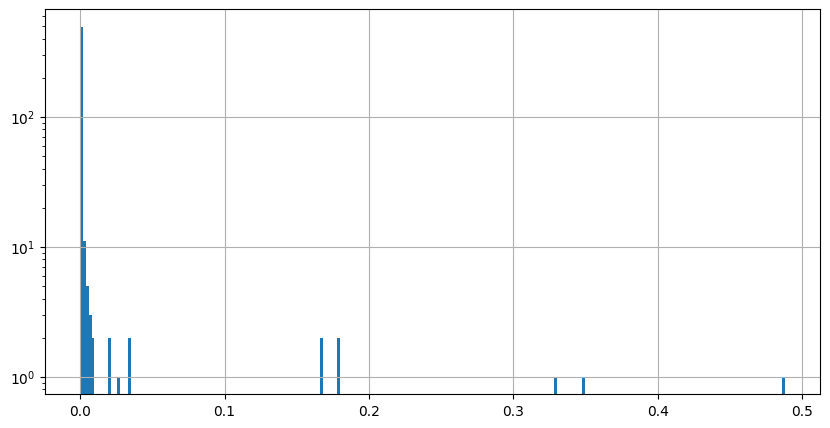

In [28]:
songs['instrumentalness'].hist(bins=250, log=True)

plt.show()

In [29]:
songs[songs['instrumentalness'] > 0.04]['instrumentalness']

74     0.328
97     0.348
117    0.488
179    0.166
188    0.179
196    0.166
205    0.179
Name: instrumentalness, dtype: float64

In [30]:
songs['low_instrumentalness'] = (songs['instrumentalness'] >= 0.05) & (songs['instrumentalness'] < 0.25)
songs['medium_instrumentalness'] = (songs['instrumentalness'] >= 0.25)
songs.drop(columns=['instrumentalness'], inplace=True)

print(songs['low_instrumentalness'].value_counts(), '\n')
print(songs['medium_instrumentalness'].value_counts())

low_instrumentalness
False    522
True       4
Name: count, dtype: int64 

medium_instrumentalness
False    523
True       3
Name: count, dtype: int64


#### Valence

,name,album,track_number,acousticness,danceability,energy,liveness,loudness,speechiness,tempo,valence,popularity,duration,taylors_version,performed_live,not_first_release,low_instrumentalness,medium_instrumentalness
360,Shake It Off,1989,6,0.0647,0.647,0.800,0.334,-5.384,0.165,160.078,0.942,53,219.2,False,False,True,False,False
379,Shake It Off,1989,6,0.0561,0.647,0.785,0.148,-5.414,0.165,160.015,0.943,73,219.2,False,False,False,False,False


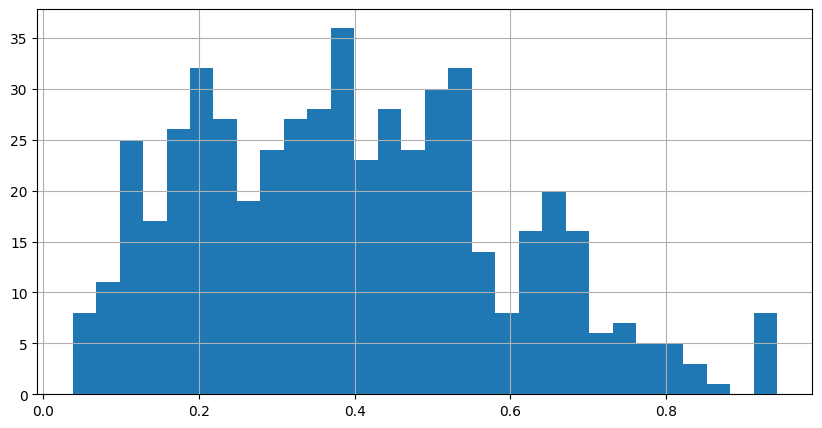

In [31]:
songs['valence'].hist(bins = 30)
songs.loc[songs['valence'] > 0.93]

#### Tempo

<Axes: >

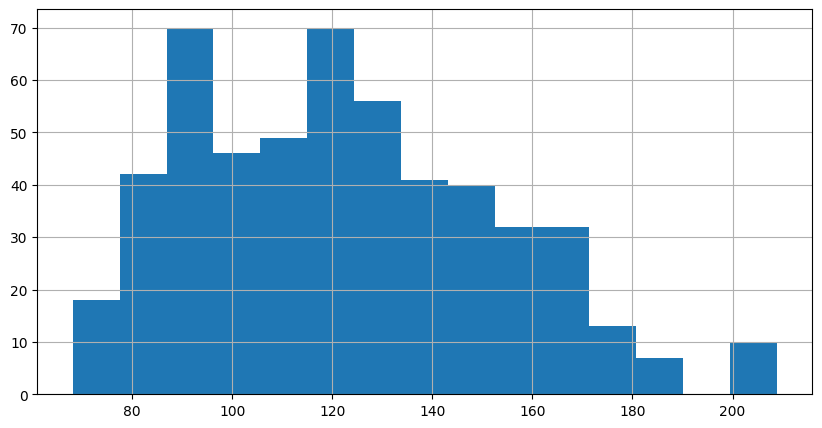

In [32]:
songs['tempo'].hist(bins = 15)

#### Speechiness

<Axes: >

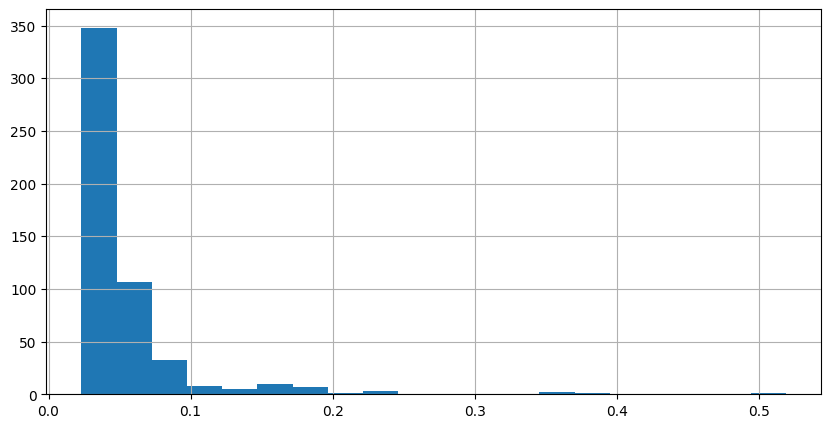

In [33]:
songs['speechiness'].hist(bins = 20)

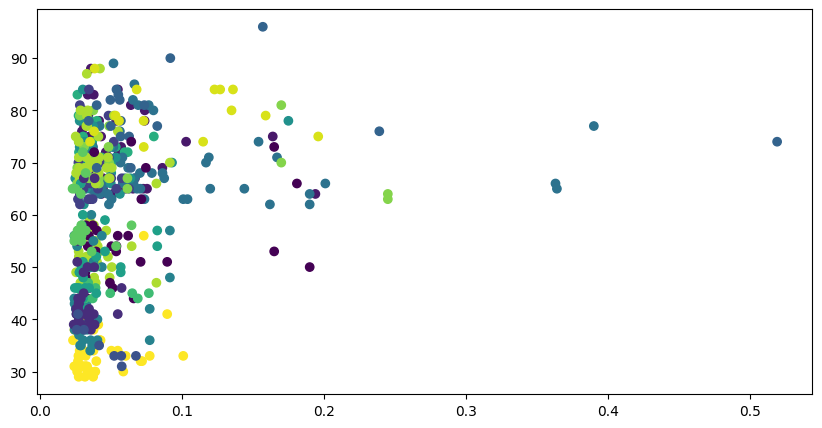

In [34]:
plt.scatter(songs['speechiness'], songs['popularity'], c=songs['album'].astype('category').cat.codes)
plt.show()

In [35]:
songs['spoken_section'] = songs['speechiness'] > 0.33 
songs.drop(columns=['speechiness'], inplace=True)

songs[songs['spoken_section']]

,name,album,track_number,acousticness,danceability,energy,liveness,loudness,tempo,valence,popularity,duration,taylors_version,performed_live,not_first_release,low_instrumentalness,medium_instrumentalness,spoken_section
72,Vigilante Shit,Midnights,8,0.157,0.867,0.272,0.1180,-11.014,79.962,0.157,66,164.801,False,False,True,False,False,True
95,Vigilante Shit,Midnights,8,0.160,0.870,0.279,0.1210,-11.134,79.996,0.160,65,164.801,False,False,True,False,False,True
115,Vigilante Shit,Midnights,8,0.173,0.798,0.277,0.1210,-11.096,79.846,0.163,77,164.801,False,False,False,False,False,True
276,I Forgot That You Existed,Lover,1,0.298,0.664,0.316,0.0812,-10.345,92.875,0.541,74,170.640,False,False,False,False,False,True


## One-hot encoding columns

In [36]:
album_dummies = pd.get_dummies(songs['album'])
songs = pd.concat([songs, album_dummies], axis=1)

## train-test split

In [37]:
from sklearn.model_selection import train_test_split

X = songs.drop(columns = {'popularity'}).set_index(['name', 'album'])
y = songs['popularity'] / 100

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
X_train.head(2)

,,track_number,acousticness,danceability,energy,liveness,loudness,tempo,valence,duration,taylors_version,...,Red,Red (Taylor's Version),Speak Now,Speak Now (Taylor's Version),Speak Now World Tour Live,Taylor Swift,evermore,folklore,reputation,reputation Stadium Tour Surprise Song Playlist
name,album,,,,,,,,,,,,,,,,,,,,,
"You're On Your Own, Kid",Midnights,5,0.4230,0.694,0.386,0.126,-10.312,120.044,0.390,194.206,False,...,False,False,False,False,False,False,False,False,False,False
Fearless,Fearless,7,0.0364,0.598,0.714,0.310,-4.397,99.979,0.467,242.000,False,...,False,False,False,False,False,False,False,False,False,False


### Standarizing variables & box-cox transformation

In [39]:
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns
for column in numerical_columns:
    if column in ['acousticness', 'liveness', 'track_number']: # we don't add track_number to preserve the significance of the track number
        X_train[column], lambda_val = boxcox(X_train[column])
        X_test[column] = boxcox(X_test[column], lmbda=lambda_val)

    else:
        min_val = X_train[column].min()
        max_val = X_train[column].max()
        X_train[column] = (X_train[column] - min_val) / (max_val - min_val)
        X_test[column] = (X_test[column] - min_val) / (max_val - min_val)

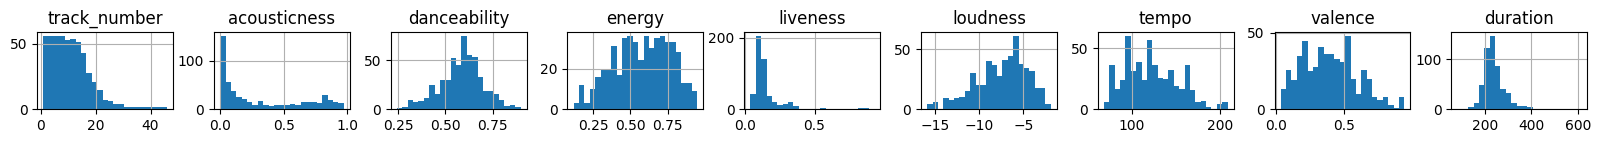

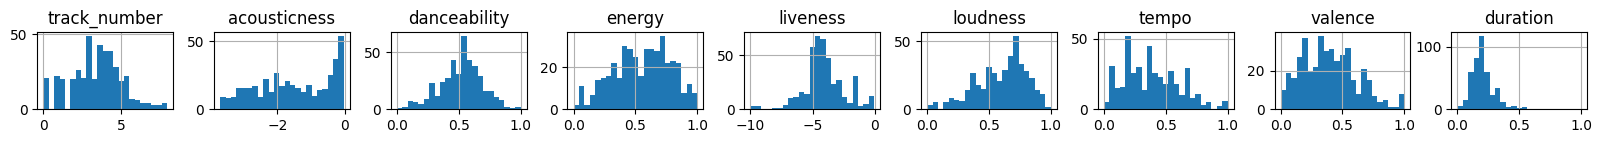

In [40]:
songs.drop(columns=['popularity']).hist(bins=23, layout=(1, -1), figsize=(20, 1))
X_train.hist(bins=23, layout=(1, -1), figsize=(20, 1))
plt.show()

In [41]:
X_test.head(2)

,,track_number,acousticness,danceability,energy,liveness,loudness,tempo,valence,duration,taylors_version,...,Red,Red (Taylor's Version),Speak Now,Speak Now (Taylor's Version),Speak Now World Tour Live,Taylor Swift,evermore,folklore,reputation,reputation Stadium Tour Surprise Song Playlist
name,album,,,,,,,,,,,,,,,,,,,,,
The Best Day,reputation Stadium Tour Surprise Song Playlist,1.334622,-0.425106,0.651376,0.396635,-3.270024,0.524534,0.415923,0.381625,0.214042,False,...,False,False,False,False,False,False,False,False,False,True
Starlight,Red,4.468703,-2.533779,0.620795,0.792067,-2.394763,0.721806,0.415565,0.606890,0.153004,False,...,True,False,False,False,False,False,False,False,False,False


In [42]:
X_train.to_csv('X_train.csv', index=True)
X_test.to_csv('X_test.csv', index=True)

y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)